# Auto Crop
Automatically cleanup our data set

In [471]:
import os
import numpy as np
import get_color_range
import image_utils
import cv2
import logging
import json
from random import shuffle

from sklearn.cluster import MiniBatchKMeans
from keras.preprocessing import image

import mr

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)

Populating the interactive namespace from numpy and matplotlib


In [421]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
def bgr_as_rgb(img):    
    b,g,r = cv2.split(img)
    return cv2.merge([r,g,b])

def plot_grid(imgs, is_gray=False, file_name=None):
    d = int(len(imgs)**.5)
    fig, axes = plt.subplots(d, d, sharex=True, sharey=True, figsize=(12,12),)
    for ii, ax in enumerate(axes.flatten()):
        if is_gray:
            ax.imshow(imgs[ii], aspect='equal', cmap=plt.get_cmap('gray'))
        else:
            ax.imshow(bgr_as_rgb(imgs[ii]), aspect='equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    if file_name:
        plt.savefig(file_name)

In [333]:
# get all of the images we want to work with
images = []
root = 'extra/ISIC-images/SONIC/'
for file in os.listdir(root):
    if file.endswith('.json') or file.endswith('proxy.jpg') or file.endswith('rect.jpg'):
        continue
    
    images.append(os.path.join(root, file))    

In [290]:
# randomize
shuffle(images)

In [109]:
# get a random set of samples
img_size = 128
img_prx = [image_utils.create_proxy(image, img_size, img_size) for image in images[:64]]
img_rct = [image_utils.convert_to_rect(image) for image in images[:64]]

In [112]:
print img_prx[0], img_rct[0]

extra/ISIC-images/SONIC/ISIC_0003598_proxy.jpg extra/ISIC-images/SONIC/ISIC_0003598_rect.jpg


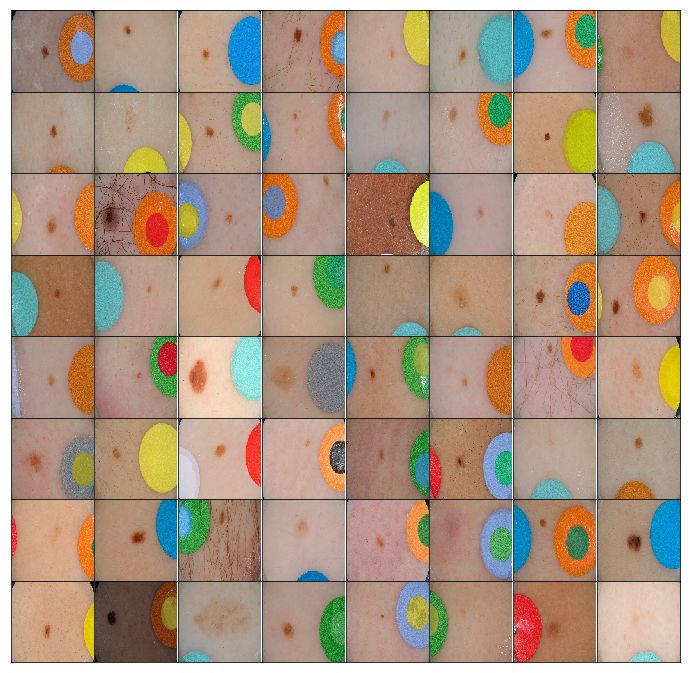

In [113]:
prx_d = [cv2.imread(ii) for ii in img_prx]
rct_d = [cv2.imread(ii) for ii in img_rct]
plot_grid(prx_d)    

## Posterize

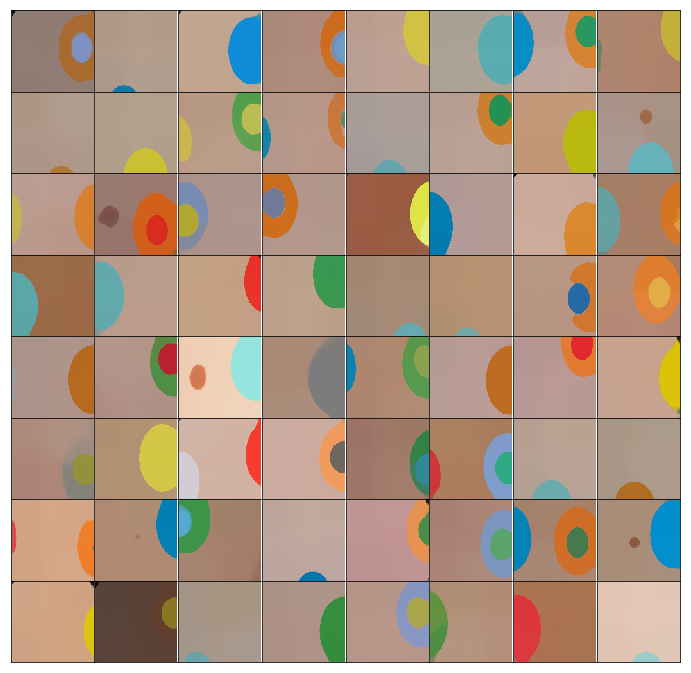

In [430]:
def pre_process(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    
    img_blur = cv2.medianBlur(img, 25)
    img_bgr = cv2.pyrMeanShiftFiltering(img_blur, 35, 35, 3)
    
#     kernel = np.ones((5,5), np.uint8)
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
#     img_bgr = cv2.erode(img_bgr, kernel, iterations=1)
#     img_bgr = cv2.dilate(img_bgr, kernel, iterations=1)
    
    return img_gray, img_bgr

plot_grid([pre_process(ii)[1] for ii in prx_d])

## Mask patches
Create a mask for all patches

In [472]:
def create_patch_mask_inner(img_rgb=None,
                            img_gray=None,
                            img_mask=None,
                            channels=['h','s','v'],
                            lw_bnd=[30, 75, 160],
                            up_bnd=[255, 255, 255],
                            border=0.1,
                            show=0
                            ):
    
    logging.info('create_patch_mask_inner show:{}'.format(show))
    fnd_ptchs = {}  # number of found patches per channel

    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    
    nv = h.shape[0] * h.shape[1]    
    logging.info('array size: {}'.format(nv))
    
    img_channels = []
    if 'h' in channels:
        img_channels.append(h)
    if 's' in channels:
        img_channels.append(s)
    if 'v' in channels:
        img_channels.append(v)
        
    for ii, jj in enumerate(img_channels):
        img_edged = []

        if show == 1:
            plt.imshow(np.hstack([img_gray, jj]), cmap=plt.get_cmap('gray'))
            plt.show()

        # go through the different boundaries
        for lw, up in zip(lw_bnd, up_bnd):
            _, thresh = cv2.threshold(jj, lw, up, cv2.THRESH_BINARY)
            
            # make we're not cutting everything out...
            nt = np.count_nonzero(thresh)/float(nv)            
            logging.info("{} Normalized threshold: {}".format(ii, nt))
            if nt > 0.75:
                continue
            
            img_edged = cv2.Canny(thresh, 0, 255)

            if show == 2:
                plt.imshow(
                    np.hstack([img_gray, jj, thresh, img_edged]), cmap=plt.get_cmap('gray'))
                plt.title('{}: Channel {}, bound {} {}'.format(ii, 'hsv'[ii], lw, up))
                plt.show()

            # minimum number of positive samples
            ns = np.count_nonzero(img_edged)
            if ns < 25:                
                logging.info('{}: Not enough edges {}'.format(ii, ns))
                continue

            im2, contours, hierarchy = cv2.findContours(img_edged.copy(),
                                                        cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            for d, c in enumerate(contours):
                x, y, w, h = cv2.boundingRect(c)
                area = w*h
                if area < 150:
                    logging.info('{}: {} area to small'.format(ii, d))
                    continue

                xlp = x / float(img_size)
                xrp = (x+w) / float(img_size)
                ytp = y / float(img_size)
                ybp = (y+h) / float(img_size)
                
                logging.info('{}:{} rectangle X[{}:{}] Y[{}:{}]'.format(ii, d, xlp, xrp, ytp, ybp))

                # skip any shapes that are floating in the middle of the image
                if xlp > border and ytp > 0 \
                and ybp < (1-border) and xrp < (1-border):
                    logging.info('{}: {} not attached to any border: X[{}:{}] Y[{}:{}]'.format(ii, d, xlp, xrp, ytp, ybp))
                    continue

                # make sure that horizontal blocks are connected to the upper or lower border
                if w > h:
                    if ytp > border and ybp < (1-border):
                        logging.info('{}: {} not attached to top or bottom border: X[{}:{}] Y[{}:{}]'.format(ii, d, xlp, xrp, ytp, ybp))
                        continue

                # make sure that vertical blocks are connected to the left and right border
                # unless they are fully connected to top and bottom
                if h > w:
                    if ytp == .0 and ybp == 1.:                        
                        logging.info('info: X[{}:{}] Y[{}:{}]'.format(xlp, xrp, ytp, ybp))
                        logging.info('x {} w {}'.format(x, w))
                        if xlp > .6:
                            xrp = 1.0
                            w = img_size - x
                        elif xlp < 0.4:
                            xrp = 0.0
                            w += x
                            x = 0

                    elif xlp > border and xrp < (1-border):                        
                        logging.info('not attached to left or right border: X[{}:{}] Y[{}:{}]'.format(xlp, xrp, ytp, ybp))
                        continue

                # draw a rectangle where the patch is
                if not fnd_ptchs.has_key('hsv'[ii]):
                    fnd_ptchs['hsv'[ii]] = 0
                fnd_ptchs['hsv'[ii]] += 1
                cv2.rectangle(img_mask, (x, y), (x+w, y+h),
                              (255, 255, 255), -1)

    return img_mask, fnd_ptchs

In [474]:
def create_patch_mask(img, **kwargs):
    logging.info('create_patch_mask {}'.format(kwargs))
    
    show = kwargs['show'] if kwargs.has_key('show') else 0
    border = kwargs['border'] if kwargs.has_key('border') else 0.1
    channels = kwargs['channels'] if kwargs.has_key('channels') else ['h','s','v']
    
    # posterize image
    img_gray, img_bgr = pre_process(img)
    img_white = img_gray.copy()
    img_white.fill(0)
    
    # collect bound ranges so we can iterate over them
    lw_bnds = kwargs['lw_bnds'] if kwargs.has_key('lw_bnds') else [[30]]
    up_bnds = kwargs['up_bnds'] if kwargs.has_key('up_bnds') else [[255]]
    kwargs.pop('lw_bnds', None)
    kwargs.pop('up_bnds', None)
    
    # create the default arugment list
    mask_options={
        'img_rgb':img_bgr,
        'img_gray':img_gray,
        'img_mask':img_white,
        'channels':channels,
        'show':show,
        'border':border
    }        

    # iterate over the different threshold bounderies
    for i in range(len(lw_bnds)):
        mask_options['lw_bnd']=lw_bnds[i]
        mask_options['up_bnd']=up_bnds[i]
        
        img_white, fnd_ptchs = create_patch_mask_inner(**mask_options)        
        if sum([fnd_ptchs[i] for i in fnd_ptchs.keys()]) != 0:            
            logging.info('{}: Created some masks. Returning result...'.format(i))
            break;
        
    if show == 3:
        alpha = 0.75
        beta = ( 1.0 - alpha );
        dst = cv2.addWeighted(img_gray, alpha, img_white,beta,0)
        plt.imshow(np.hstack([img_gray, img_white, dst]), cmap = plt.get_cmap('gray'))
        plt.show()
        
        
    return img_gray, img_white
    

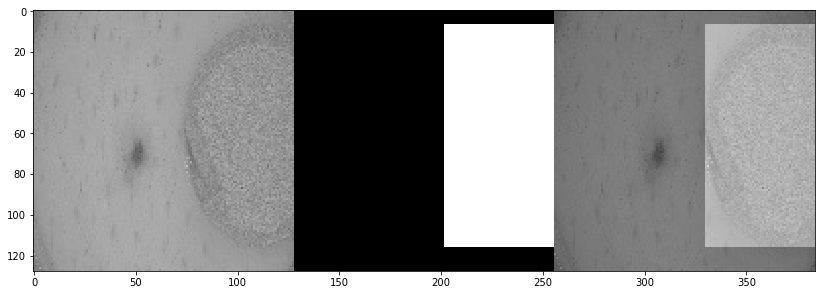

In [454]:
gray, mask = create_patch_mask(prx_d[5], 
                               channels=['h', 's'],
                               lw_bnds=[[30,120,180]], 
                               up_bnds=[[255,255,255]], 
                               show=3, 
                               verbose=1)

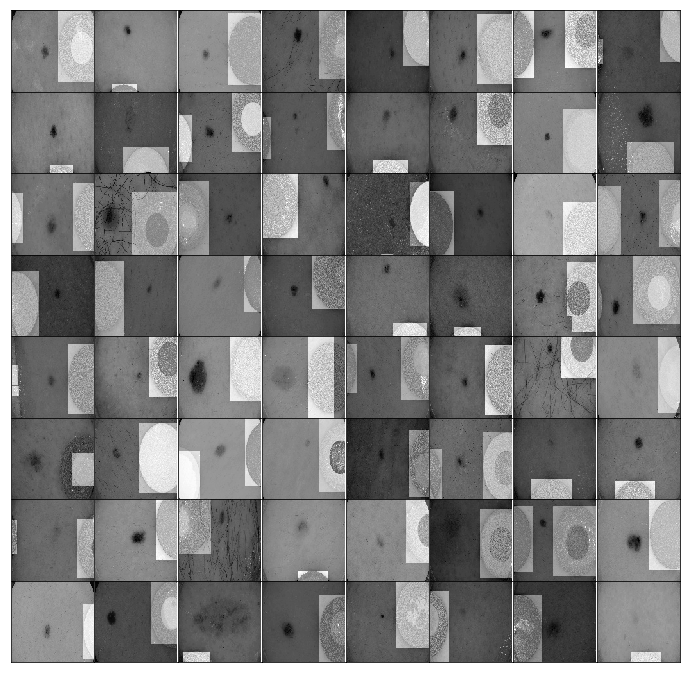

In [191]:
alpha = 0.75
beta = ( 1.0 - alpha );

img_grid = []
img_gry = []
img_msk = []
for ii in prx_d:
    gray, mask = create_patch_mask(ii,
                                   channels=['h','s'],
                                   lw_bnds=[[30, 120, 180], [160], [170]], 
                                   up_bnds=[[255, 255, 255], [255], [255]], 
                                  )
    dst = cv2.addWeighted(gray, alpha, mask,beta,0)
    img_grid.append(dst)
    img_gry.append(gray)
    img_msk.append(mask)

plot_grid(img_grid, is_gray=True)
# plot_grid(img_msk, is_gray=True)

In [237]:
def apply_patch_mask(img, mask):
    m = mask.copy()
    m[m == 255] = 1
    lx, ty, rx, by = mr.minRect(m)

    # create new mask using the minimum rectangle
    res_mask = mask.copy()
    res_mask.fill(0)
    cv2.rectangle(res_mask, (ty, lx), (by, rx), (255,255,255), -1)
    
    res_img = cv2.bitwise_and(img,img,mask=res_mask)
    return res_img, res_mask, [(lx, ty), (rx, by)]

## Test apply patch

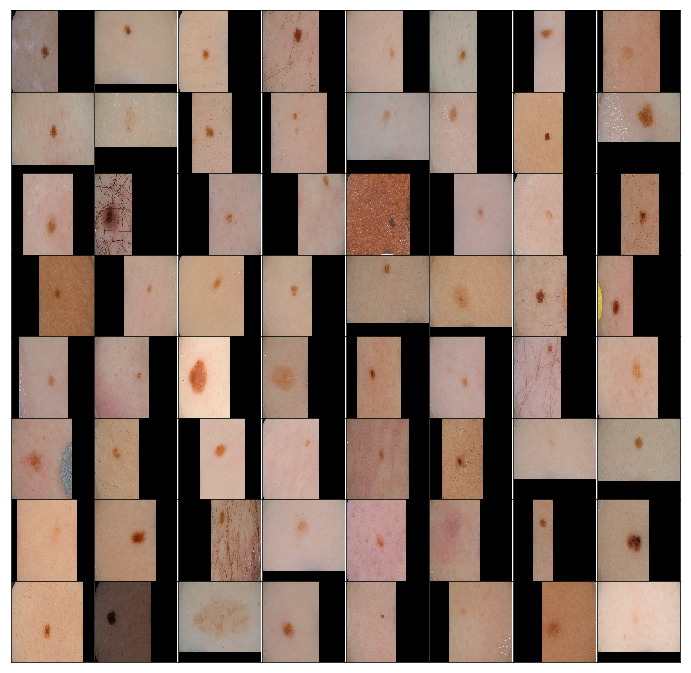

In [245]:
rect_img = []
rect_msk = []
rect_msk_dim = []
for msk, bgr in zip(img_msk, prx_d):
    r_bgr, r_msk, r_msk_dim = apply_patch_mask(bgr, msk)
    rect_img.append(r_bgr)
    rect_msk.append(r_msk)
    rect_msk_dim.append(r_msk_dim)
    
plot_grid(rect_img, is_gray=False)

In [239]:
def remap_value(value, low1, high1, low2, high2):
    return low2 + (value - low1) * (high2 - low2) / (high1 - low1)

remap_value(75, 25, 75, 2, 1)

1

## Square around keypoint
Now the patches are out of the picture, we can concentrate on one thing, finding the mole. Activate mole hunter.

In [444]:
def square_around_keypoint(img, area_range=[25,75], show=0, verbose=0):
    keypoint_rect = []        
    im = img.copy()
    im_with_keypoints = img.copy()
    img_size = img.shape[0]
    
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minConvexity = 0.1
    
    # get the biggest possible blob
    for i in reversed(range(area_range[0], area_range[1])):
        params.minArea = i
        detector = cv2.SimpleBlobDetector_create(params)
        keypoints = detector.detect(im)
        if keypoints:
            if verbose:
                msg = 'minArea {}'.format(c)
                msg += ', number of keypoints {}'.format(len(keypoints))
                msg += ', diameter {}'.format(keypoints[0].size)
                msg += ', points {}'.format(keypoints[0].pt)
                logger.info(msg)
                
            im_with_keypoints = cv2.drawKeypoints(im, 
                                                  keypoints, 
                                                  np.array([]), 
                                                  (0,0,255), 
                                                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            
            kp_dia.append(keypoints[0].size)
            
            m = remap_value(keypoints[0].size, 10, 80, 2, 1)
            d = keypoints[0].size * m
            cx, cy = keypoints[0].pt
            x1 = int(cx - d/2)
            y1 = int(cy - d/2)
            x2 = int(x1 + d)
            y2 = int(y1 + d)
            cv2.rectangle(im_with_keypoints, (x1, y1), (x2, y2), (255,0,0), 1)
            
            img_sizef = float(img_size)
            keypoint_rect = [(x1/img_sizef, y1/img_sizef), (x2/img_sizef, y2/img_sizef)]
            break; break;
    
    if show == 1:
        plt.imshow(bgr_as_rgb(im_with_keypoints))
        plt.show()
                            
    return keypoint_rect, im_with_keypoints

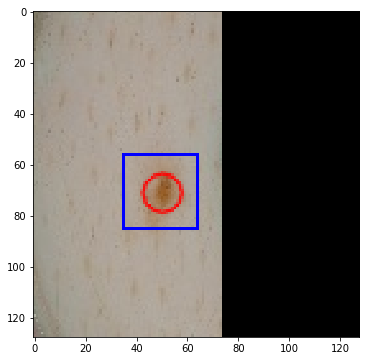

In [445]:
rak, _ = square_around_keypoint(rect_img[5], show=1, verbose=1)

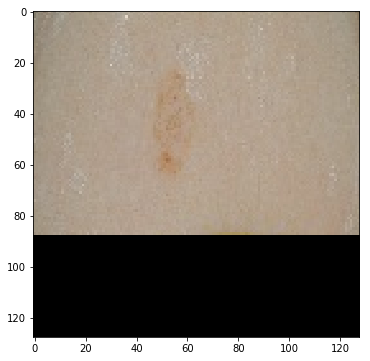

No keypoints found


In [441]:
rak, _ = square_around_keypoint(rect_img[9], show=1, verbose=1)
if not rak:
    print 'No keypoints found'

## Center square
Since our ouput format is a square we need to convert our rectangle into a square and position the square into the center of the original rectangle. This isn't an ideal solution since we're not certain the point of interest is the middle of the rectangle. Imperical evidence does show this the case most of time.

In [426]:
def center_rect(dim, verbose=0):    
    logging.info("dim: {}".format(dim))
    
    h = dim[1][0] - dim[0][0] 
    w = dim[1][1] - dim[0][1] 
    v = w if w < h else h
    x_offset = (w - v)*.5
    y_offset = (h - v)*.5
    
    logging.info("value {}".format(v))
    logging.info("offset [{},{}]".format(x_offset, y_offset))

    x1 = int(dim[0][1] + x_offset)
    x2 = int(x1 + v)
    y1 = int(dim[0][0] + y_offset)
    y2 = int(y1 + v)
    result = [(x1, y1),(x2, y2)]
    
    logging.info('result {}'.format(result))
    return result 

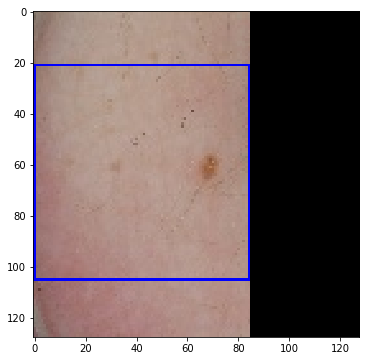

In [438]:
ii = rect_img[33].copy()
rect = center_rect(rect_msk_dim[33], verbose=1)
cv2.rectangle(ii, rect[0], rect[1], (255,0,0), 1)
plt.imshow(bgr_as_rgb(ii))
plt.show()

## Test square around keypoint

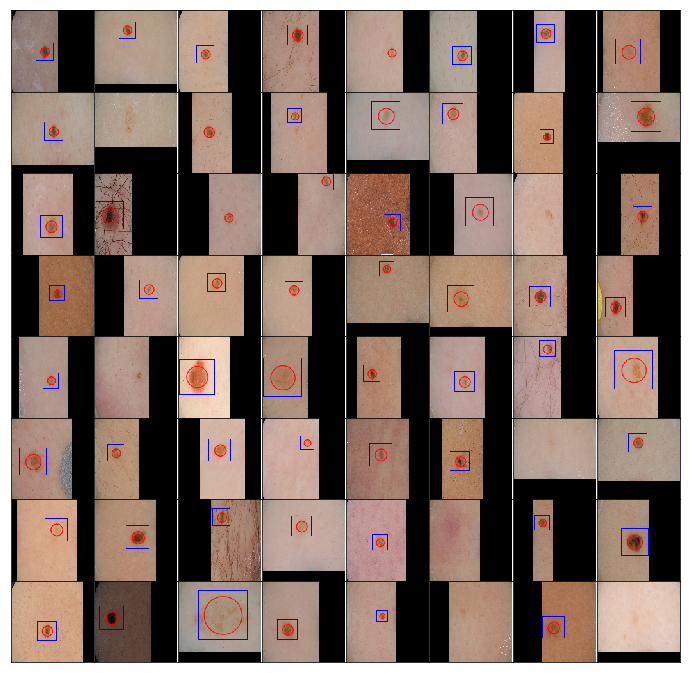

In [203]:
plot_grid([square_around_keypoint(ii)[1] for ii in rect_img], is_gray=False)

In [209]:
rak_d = [square_around_keypoint(ii)[0] for ii in rect_img]

## Crop square around keypoint
Now we found what we're looking for we just need to cut it out from the original so we can have the maximum amount of detail.

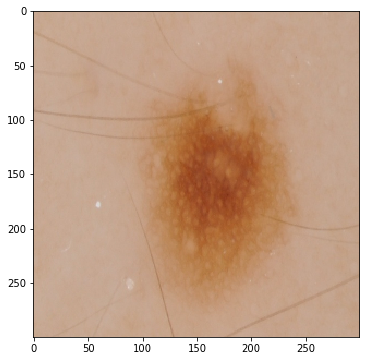

In [381]:
def crop_and_reshape(img, norm_rect=[(0.1,0.5),(0.5,0.9)], width=299):
#     print('crop_and_reshape {} {}'.format(norm_rect, width))        
    
    sl, _, _ = img.shape
    x1 = int(sl * norm_rect[0][0])
    y1 = int(sl * norm_rect[0][1])
    x2 = int(sl * norm_rect[1][0])
    y2 = int(sl * norm_rect[1][1])
    crop_img = img[y1:y2, x1:x2]
    resz_img = cv2.resize(crop_img, (width,width), interpolation=cv2.INTER_CUBIC)
    return resz_img

final = crop_and_reshape(rct_d[2], norm_rect=rak_d[2], width=300)
plt.imshow(bgr_as_rgb(final))
plt.show()

In [468]:
# TODO: separate proxy resolution + output resolution
# TODO: update json with processing info
def auto_crop(bgr, pwh=128, owh=299, show_debug=False, save_debug=False):
    """
    pwh = proxy width and height in pixels
    owh = output width and height in pixels
    """
    fpwh = float(pwh)
    root, ext = os.path.splitext(bgr)
    record = {
        'found_patches':False,
        'found_mole':False        
    }
    
    logging.info('Reading in image {}'.format(bgr))    
    meta = json.load(open(root+'.json'))    
    fll_bgr = cv2.imread(bgr)
    sqr_bgr = cv2.imread(image_utils.convert_to_rect(bgr))
    prx_bgr = cv2.imread(image_utils.create_proxy(bgr, pwh, pwh))
    
    if show_debug:
        plt.imshow(bgr_as_rgb(prx_bgr))
        plt.show()
    
    logging.info('\nCreating patch mask')        
    prx_gry, prx_msk = create_patch_mask(prx_bgr,
                                   channels=['h','s'],
                                   lw_bnds=[[30, 120, 180], [160], [170]], 
                                   up_bnds=[[255, 255, 255], [255], [255]],
                                   show=2 if show_debug == 1 else 0
                                  )
    if np.count_nonzero(prx_msk) > 0:
        record['found_patches'] = True
    
    inb = cv2.bitwise_and(prx_bgr,prx_bgr,mask = 255-prx_msk)
    
    if show_debug:
        plt.imshow(bgr_as_rgb(inb))
        plt.show()
    
    logging.info('\nApplying mask')    
    p_bgr, p_msk, p_msk_dim = apply_patch_mask(prx_bgr, prx_msk)
    
    if show_debug:
        plt.imshow(bgr_as_rgb(p_bgr))
        plt.show()
    
    logging.info('\nFinding keypoint')        
    sak_d, bgr_wk = square_around_keypoint(p_bgr, verbose=0, show=0)
    if not sak_d:        
        logging.info('No keypoint was found')            
        rect = center_rect(p_msk_dim, verbose=0)
        sak_d = [(rect[0][0]/fpwh, rect[0][1]/fpwh), (rect[1][0]/fpwh, rect[1][1]/fpwh)]
    else:
        record['found_mole'] = True
            
    logging.info('\nCropping image')        
    final = crop_and_reshape(sqr_bgr, norm_rect=sak_d, width=owh)
            
    # show summary and save if requested
    debug = np.hstack([bgr_as_rgb(ii) for ii in [prx_bgr, 
                                                 inb, 
                                                 p_bgr, 
                                                 bgr_wk, 
                                                 cv2.resize(final, (pwh,pwh), interpolation=cv2.INTER_CUBIC)]])
    plt.imshow(debug)
    if save_debug:
        filename=root + '_debug' + ext
        logging.info('saving {}'.format(filename))        
        plt.savefig(root+'_debug'+ext)
        
    # save final result
    filename=root+'_final'+ext
    cv2.imwrite(filename, final)    
    
    # Extend json with information on how succesfull our image processing step was. 
    meta['auto_crop'] = record
    json.dump(meta, open(root+'_final.json', 'w')) 
        
    logging.info('done')

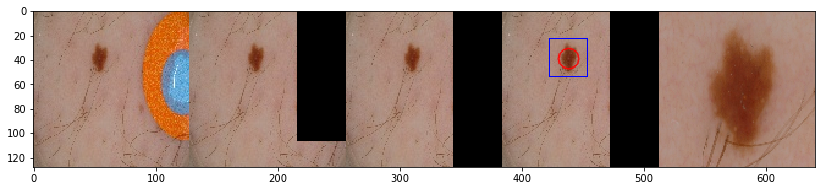

In [475]:
# auto_crop(images[5], save_debug=True)
logger.setLevel(logging.WARNING)
auto_crop('extra/ISIC-images/SONIC/ISIC_0003943.jpg', show_debug=0, save_debug=True)

[None, None, None, None, None]

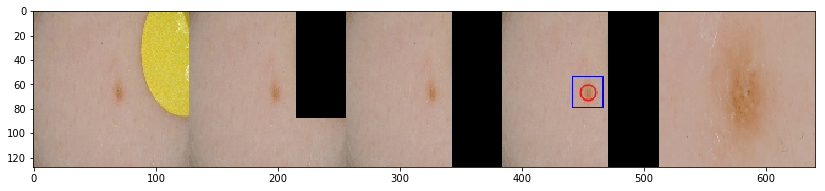

In [448]:
[auto_crop(img, save_debug=True) for img in images[:5]]